### 一、导入工具包

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 二、数据预处理

数据文件是台中国台湾省（2014/1/1~2014/12/20）的空气质量监测数据，一共涉及18个空气质量指标，共240天24小时的数据。为了避免乱码问题，首先删除训练集源文件的前两列：日期列和“代”列（源文件标号为“代”，该列数据都是汉字伦）,并使用gbk编码打开。

数据的预处理主要分为两步：

- 构建使用其他17个指标预测PM2.5的训练集
- 构建每个指标前 $n$ 天数据预测 $n+1$ 数据的训练集

In [2]:
def normalization(data):
    '''
        采用z-score标准化数据
        @param:
            需要标准化的数据，numpy.ndarray类型
        @return:
            归一化后的数据
    '''
    mu = np.mean(data, axis=1, keepdims=True)
    std = np.std(data, axis=1 ,keepdims=True)
    data = (data - mu) / std
    return data

In [3]:
def process_for_17_pm(data_path, path_to_save):
    '''
    从源文件中加载数据，并且采用z-score方法对数据进行标准化，然后按照80%训练集
    10%交叉验证集，10%测试集划分数据
        @param: data_path csv文件路径
        
        (X,Y)训练数据二元组
            x:包含去除PM2.5指标剩余的17个指标。
              按列存储，即每一列表示一个时间的17个指标的样本，按照时间顺序依次排列（第1列数据
              是2014/1/1 0时数据，第2列是214/1/1 1时数据，依次类推）。
            y:对应时刻的PM2.5值
    '''
    # 指定第一行为列索引，第一列为行索引，将RAINFLALL所在行NR替换为NAN
    df = pd.read_csv(data_path, header=0, index_col=0, na_values='NR', 
                 encoding='gbk')
    
    # 将NaN替换为0
    df = df.fillna(0)
    Y = df.loc['PM2.5'].values
    Y = y.reshape(1,-1)
    
    df = df.drop(index='PM2.5')
    
    # 计算一个有多少天的数据
    days = df.shape[0] // 17
    
    X = df.values
    X = np.concatenate(np.vsplit(X, days), axis=1)
    
    X = normalization(X)
    Y = normalization(Y)
    
    m = Y.shape[1]
    size = (int)(m*0.2)
    

    valid_test = np.random.choice(m, size, replace=False)
    valid_test = np.split(valid_test, 2)
    
    valid = valid_test[0]
    X_valid = X[:, valid]
    Y_valid = Y[:, valid]
    
    test = valid_test[1]
    X_test = X[:, test]
    Y_test = Y[:, test]
    
    X = np.delete(X, valid_test, axis=1)
    Y = np.delete(Y, valid_test, axis=1)
    
    path = path_to_save
    
    np.save(path + 'Xvalid.npy',X_valid)
    np.save(path + 'Yvalid.npy',Y_valid)
    
    np.save(path + 'Xtest.npy',X_test)
    np.save(path + 'Ytest.npy',Y_test)
    
    np.save(path + 'Xtrain.npy',X)
    np.save(path + 'Ytrain.npy',Y)
    
    print('from 17 features inferring PM2.5 training data processing is OK')

# data_path = 'data/train.csv'

In [4]:
# 预处理使用17个指标预测PM2.5的数据并保存

# data_path = 'data/train.csv'
# path = 'data/17_pm25/'
# process_for_17_pm(data_path)


In [5]:
def get_feature_train_data(feature, fname, path_to_save ,window=9):
    '''
    将数据集中所有属于该指标的数据按照窗口值生成训练数据，一个列向量为一个样本。
    并按照8:1:1的比例划分训练集、验证集和测试集，最后保存数据到本地。
    @param:
        feature：指标数组矩阵
        fname：指标名，如NO、PM2.5等
        path_to_save：保存数据的路径
        window：选取擦窗口内的值预测下一时刻的数据
    '''
    X = []
    Y = []
    i = 0
    j = i + window
    while j < 24:
        X.append(feature[:, i:j])
        Y.append(feature[:, j])
        i += 1
        j += 1
    X = np.concatenate(X, axis=0)
    Y = np.concatenate(Y, axis=0)
    X = X.T
    m = Y.shape[0]
    Y = Y.reshape(1, m)
    
    # 选取10% 的交叉验证集和10% 的测试集
    size = (int)(m*0.2)

    valid_test = np.random.choice(m, size, replace=False)
    valid_test = np.split(valid_test, 2)
    
    valid = valid_test[0]
    X_valid = X[:, valid]
    Y_valid = Y[:, valid]
    
    test = valid_test[1]
    X_test = X[:, test]
    Y_test = Y[:, test]
    
    X = np.delete(X, valid_test, axis=1)
    Y = np.delete(Y, valid_test, axis=1)
    
    path = path_to_save + fname + '_'
    np.save(path + 'Xvalid.npy',X_valid)
    np.save(path + 'Yvalid.npy',Y_valid)
    
    np.save(path + 'Xtest.npy',X_test)
    np.save(path + 'Ytest.npy',Y_test)
    
    np.save(path + 'Xtrain.npy',X)
    np.save(path + 'Ytrain.npy',Y)

In [6]:
def process_for_feature_infer(data_path):
    df = pd.read_csv(data_path, header=0, index_col=0, na_values='NR', 
                 encoding='gbk')
    df = df.fillna(0)
    
    ind = df.index
    path_to_save = 'data/features/'
    for k in range(18):
        i = ind[k]
        feature = df.loc[i].values
        mu = np.mean(feature)
        std = np.mean(feature)
        feature = (feature - mu) / std
        get_feature_train_data(feature, i, path_to_save)
    print('training data for infer feature from previous n hours to n+1 hour is OK')

In [84]:
# 预处理每个指标使用前n天数据预测n+1天数据

# data_path = 'data/train.csv'
# process_for_feature_infer(data_path)

In [8]:
def initialize_parameter(dim):
    '''
    初始化参数
        @param:
            参数的维度信息
        @return:
            随机初始化后的参数
    '''
    w = np.random.randn(1,dim)
    b = np.zeros((1,1))
    return w,b

In [236]:
# 测试参数初始化函数
# w,b = initialize_parameter(17)
# print('W:', w)
# print('b:', b)

### 三、训练模型

线性模型的为
$$\hat{y} = \sum_i w_i \cdot x_i + b$$

衡量模型优劣的代价函数（Loss Function）为 Mean Square Error
$$L(y, \hat{y}) = \frac{1}{2} \sum_k (\hat{y}_k - y_k)^2$$

采用梯度下降法（Gradient Descent）求解
$$\frac{\partial L}{\partial w_i } = (\hat{y}_k - y_k) x_i$$

#### 3.1 训练模型的基本函数

In [9]:
def get_batch(index, batch_size, X, Y):
    '''
    根据batch size从训练集中获取训练数据
        @param:
            index：起点下标
            batch_size：batch的大小
            X：训练特征集（特征按列排放，即每一列就是一个训练样本）
            Y：训练标记集（是一个行向量）
        @return:
            返回一个batch的训练数据或者None（数据已经取完）
    
    '''
    x = None
    y = None
    j = index + batch_size
    if j <= X.shape[1]:
        pass
    elif index < X.shape[1]:
        j = X.shape[1]
    else:
        return None, None, None
    
    x = X[:, index : j]
    y = Y[:, index : j]
    index = j
    return x, y, index
        

In [29]:
def train(w, b, X, Y, alpha=0.005, iteration=100, batch_size=252, plotError=True):
    '''
    训练模型
        @param:
            模型参数w、b，训练数据（标准化后的）X，Y。学习速率alpha，迭代次数iteration，batch size
        @return:
            返回训练好的参数w、b
    
    '''
    losses = []
    for _ in range(iteration):
        cur_index = 0
        while True:
            x, y, cur_index = get_batch(cur_index, batch_size, X, Y)
            if x is None:
                break
            
            y_ = np.dot(w, x) + b
            m = y_.shape[1]
            
            diff = y_ - y
            loss = 0.5 * np.sum(diff**2)
            losses.append(loss)
            
            dw = 1/m * np.dot(diff, x.T)
            db = 1/m * np.sum(diff, keepdims=True)
            
            w = w - alpha * dw
            b = b - alpha * db

    if plotError:
        plt.plot(losses)
        plt.xlabel('batch iteration times')
        plt.ylabel('loss')
        plt.show()
    
    print('After %d iterations with the batch size %d and learning rate %f' %(iteration, batch_size, alpha))
    print('Train set error is %.2f' % losses[-1])
    return w,b

In [55]:
def test_error(w, b, tx, ty):
    '''
        @param:
            w,b训练好的参数
            tx,ty测试集数据（已标准化）
        
    '''
    y_ = np.dot(w, tx) + b
    loss = 0.5 * np.sum((y_ - ty)**2)
    print('Valid/Test set error is %.2f' %loss)

#### 3.2训练17个指标预测PM2.5的模型


In [67]:
def main(dim, Xtrain_p, Ytrain_p, Xvalid_p, Yvalid_p,         
         alpha=0.025, iteration=1000, batch_size=256):
    w, b = initialize_parameter(dim)
    Xtrain = np.load(Xtrain_p)
    Ytrian = np.load(Ytrain_p)
    
    w,b = train(w, b, Xtrain, Ytrian,alpha,iteration,batch_size)
    print('========================')
    
    Xvalid = np.load(Xvalid_p)
    Yvalid = np.load(Yvalid_p)
    test_error(w, b, Xvalid, Yvalid)
    
    return w,b
  

In [ ]:
dim = 17
prefix = 'data/17_pm25/'

Xtrain = prefix + 'Xtrain.npy'
Ytrain = prefix + 'Ytrain.npy'


alpha = 0.025
iteration = 1000
batch_size = 512

Xvalid = prefix + 'Xvalid.npy'
Yvalid = prefix + 'Yvalid.npy'

#### 依次训练每个指标的预测模型

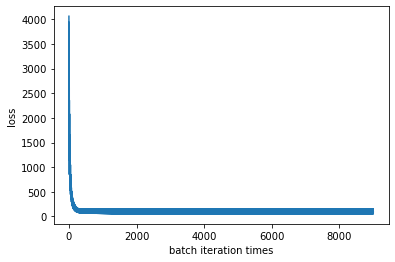

After 1000 iterations with the batch size 512 and learning rate 0.025000
Train set error is 99.35
Valid/Test set error is 104.51


In [69]:
w, b = main(dim, Xtrain, Ytrain, Xvalid, Yvalid, alpha, iteration, batch_size)

In [70]:
save_param = False

if save_param:
    np.save(prefix + 'w.npy', w)
    np.save(prefix + 'b.npy', b)

#### 3.3训练各个指标 前n天预测第n+1天数据的模型

In [87]:
def train_each_feature_estimator(feature, alpha, iteration, batch_size, save_param = False):
    print('Now training the feature:', feature)
    dim = 9
    prefix =r'data/features/' + feature + '_'
    Xtrain = prefix + 'Xtrain.npy'
    Ytrain = prefix + 'Ytrain.npy'


#     alpha = 0.025
#     iteration = 1000
#     batch_size = 256


    Xvalid = prefix + 'Xvalid.npy'
    Yvalid = prefix + 'Yvalid.npy'

    w, b = main(dim, Xtrain, Ytrain, Xvalid, Yvalid, alpha, iteration, batch_size)
    
    if save_param:
        np.save(prefix + 'w.npy', w)
        np.save(prefix + 'b.npy', b)


Now training the feature: NO2


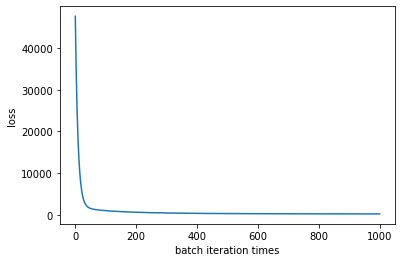

After 1000 iterations with the batch size 100000 and learning rate 0.025000
Train set error is 187.98
Valid/Test set error is 24.58


In [121]:

'''
feature_index = [
    'AMB_TEMP', 'CH4', 'CO', 'NMHC', 'NO', 'NO2',
    'NOx', 'O3', 'PM10', 'PM2.5', 'RAINFALL', 'RH',
    'SO2', 'THC', 'WD_HR', 'WIND_DIREC', 'WIND_SPEED',
    'WS_HR'
]
'''

train_each_feature_estimator('NO2', 0.025, 1000, 100000, True)

In [ ]:
train_each_feature_estimator('AMB_TEMP', 0.025, 1000, 256)

In [ ]:
train_each_feature_estimator('AMB_TEMP', 0.005, 1000, 512, True)

In [ ]:
train_each_feature_estimator('CH4', 0.025, 1000, 512, True)

In [ ]:
train_each_feature_estimator('CO', 0.025, 1000, 100000, True)

In [ ]:
train_each_feature_estimator('NMHC', 0.025, 1000, 100000, True)

In [ ]:
train_each_feature_estimator('NO', 0.025, 1000, 100000, True)

Now training the feature: O3


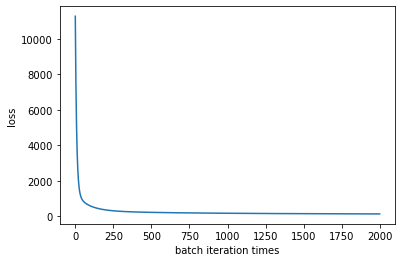

After 2000 iterations with the batch size 100000 and learning rate 0.025000
Train set error is 134.84
Valid/Test set error is 13.10


In [131]:
train_each_feature_estimator('O3', 0.025, 2000, 100000, True)

Now training the feature: PM10


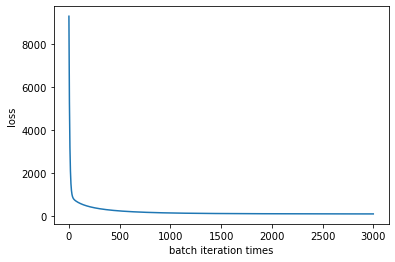

After 3000 iterations with the batch size 100000 and learning rate 0.025000
Train set error is 115.13
Valid/Test set error is 9.47


In [135]:
train_each_feature_estimator('PM10', 0.025, 3000, 100000, True)

Now training the feature: PM2.5


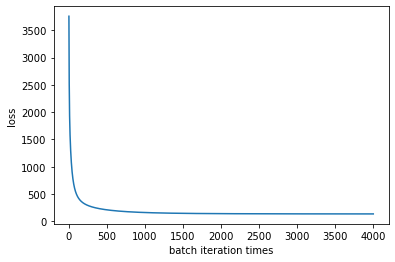

After 4000 iterations with the batch size 100000 and learning rate 0.035000
Train set error is 134.97
Valid/Test set error is 15.48


In [139]:
train_each_feature_estimator('PM2.5', 0.035, 4000, 100000, True)

Now training the feature: RAINFALL


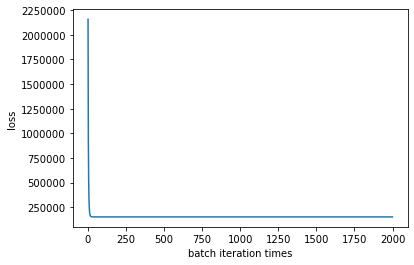

After 2000 iterations with the batch size 100000 and learning rate 0.002500
Train set error is 150505.22
Valid/Test set error is 38781.92


In [146]:
train_each_feature_estimator('RAINFALL', 0.0025, 2000, 100000, True)

Now training the feature: RH


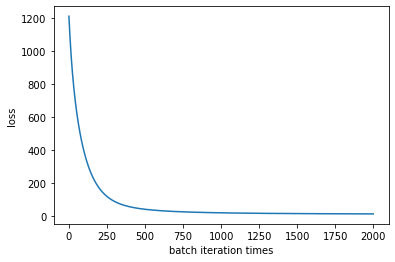

After 2000 iterations with the batch size 100000 and learning rate 0.025000
Train set error is 14.77
Valid/Test set error is 1.75


In [149]:
train_each_feature_estimator('RH', 0.025, 2000, 100000, True)

Now training the feature: SO2


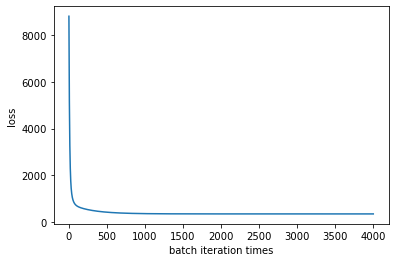

After 4000 iterations with the batch size 100000 and learning rate 0.025000
Train set error is 343.18
Valid/Test set error is 50.44


In [153]:
train_each_feature_estimator('SO2', 0.025, 4000, 100000, True)

Now training the feature: THC


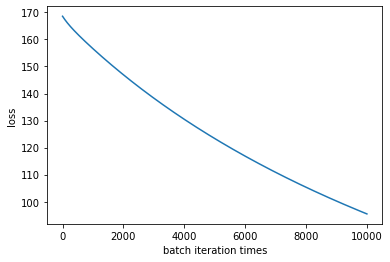

After 10000 iterations with the batch size 100000 and learning rate 0.002500
Train set error is 95.48
Valid/Test set error is 11.61


In [157]:
train_each_feature_estimator('THC', 0.0025, 10000, 100000, True)

Now training the feature: WD_HR


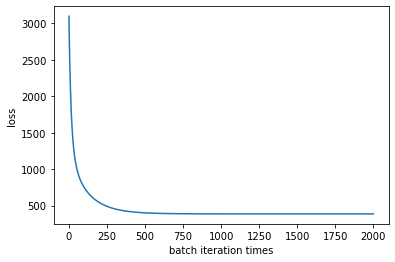

After 2000 iterations with the batch size 100000 and learning rate 0.025000
Train set error is 386.30
Valid/Test set error is 37.42


In [160]:
train_each_feature_estimator('WD_HR', 0.025, 2000, 100000, True)

Now training the feature: WIND_DIREC


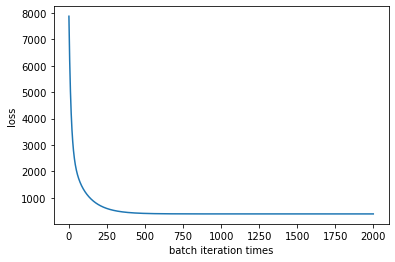

After 2000 iterations with the batch size 100000 and learning rate 0.025000
Train set error is 391.21
Valid/Test set error is 50.09


In [161]:
train_each_feature_estimator('WIND_DIREC', 0.025, 2000, 100000, True)

Now training the feature: WIND_SPEED


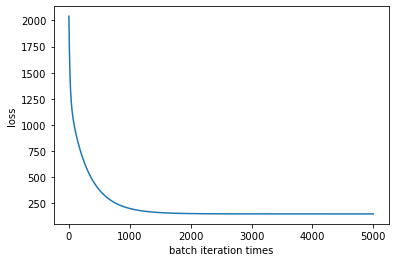

After 5000 iterations with the batch size 100000 and learning rate 0.025000
Train set error is 147.44
Valid/Test set error is 16.84


In [163]:
train_each_feature_estimator('WIND_SPEED', 0.025, 5000, 100000, True)

Now training the feature: WS_HR


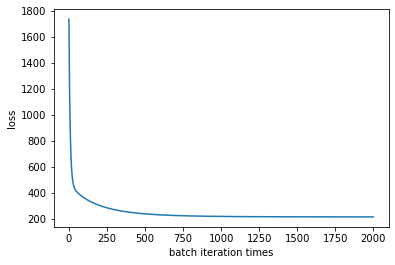

After 2000 iterations with the batch size 100000 and learning rate 0.025000
Train set error is 212.62
Valid/Test set error is 30.50


In [164]:
train_each_feature_estimator('WS_HR', 0.025, 2000, 100000, True)

### 四、模型预测

首先需要对test.csv进行预处理，删除第一列id列，同时在第一行新插入一行，并填入标号（用作数据的列索引）。


In [197]:
test_path = 'data/test.csv'
df = pd.read_csv(test_path, header=0, index_col=0, na_values='NR', 
                 encoding='gbk')
df = df.fillna(0)
feature_index = [
    'AMB_TEMP', 'CH4', 'CO', 'NMHC', 'NO', 'NO2',
    'NOx', 'O3', 'PM10', 'PM2.5', 'RAINFALL', 'RH',
    'SO2', 'THC', 'WD_HR', 'WIND_DIREC', 'WIND_SPEED',
    'WS_HR'
]
predict_feature = []
# PM2.5模型另外保存
pm25 = None
for fname in feature_index:
    feature = df.loc[fname].values
    feature = feature.T
    mu = np.mean(feature)
    std = np.std(feature)
    feature = (feature - mu) / std
    prefix = 'data/features/' + fname + '_'
    w = np.load(prefix + 'w.npy')
    b = np.load(prefix + 'b.npy')

    y_ = np.dot(w, feature) + b
    y_ = y_ * std + mu
    if fname !='PM2.5':
        predict_feature.append(y_)
    else:
        pm25 = y_


In [199]:
feature = np.concatenate(predict_feature, axis=0)
w = np.load('data/17_pm25/w.npy')
b = np.load('data/17_pm25/b.npy')
Y_hat = np.dot(w, feature) + b

In [208]:

index = [ 'id_'+ str(i) for i in range(240) ]
# result = np.concatenate([Y_hat.T, pm25.T], axis=1)
#使用预测所得的17个指标数据预测PM2.5
data_save = pd.DataFrame(Y_hat.T, index=index, columns=['value'])
data_save.to_csv('data/17pm25_result.csv')

# 直接使用前n天预测n+1天数据的模型进行预测
data_save = pd.DataFrame(pm25.T, index=index, columns=['value'])
data_save.to_csv('data/predict_result.csv')